# Suspicious Transactions Detection on AMLSim data using XGBoost (part of Omdena UNOICT Project)

The official AMLSim Project repository can be found here: https://github.com/IBM/AMLSim

AML data used in this notebook can be downloaded from directly from: https://www.dropbox.com/sh/l3grpumqfgbxqak/AAC8YT4fdn0AYKhyZ5b3Ax16a?dl=0

## Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install shap --quiet

In [3]:
from typing import Tuple

import random
import numpy as np
import pandas as pd

from sqlalchemy import create_engine

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
#from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix

import xgboost as xgb

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

import shap

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Variable settings

In [4]:
file_path = 'gdrive/My Drive/AMLSimDataSets/bank_mixed/transactions_bank_mixed.csv'
SEED = 42
TRAIN_SIZE = 0.8
NUM_BOOST_ROUND = 999
EARLY_STOPPING_ROUNDS = 10

SAMPLING_STRATEGY =  0.5 # 'auto'
# This is a SMOTE parameter: if float, it corresponds to the desired ratio of the number of samples
# in the minority class over the number of samples in the majority class after resampling

# https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
SCALE_POS_WEIGHT = 1000  # round(y.value_counts()[0] / y.value_counts()[1]) = 1097

# if WITH_SMOTE=True, cross-validation should be set to WITH_CV=False
# to keep the same data distribution on the val set and test set
WITH_SMOTE = False
WITH_CV = False

if WITH_SMOTE == True:
  SAMPLING_STRATEGY = 0.01
  SCALE_POS_WEIGHT = round(1 / SAMPLING_STRATEGY) # rescaling SCALE_POS_WEIGHT after applying SMOTE

## Data upload functions

In [5]:
# Function to upload data from the database

def import_aml_data_from_azure_pg():

  engine = create_engine('postgresql://omdenaunoct@omdena-unoct-postgresql:unoct@omdena-unoct-postgresql.postgres.database.azure.com:5432/amlsim', pool_pre_ping=True)
  transactions_df = pd.read_sql_table('transactions_bank_mixed_v2', engine, parse_dates=['tran_timestamp'])

  return transactions_df

In [6]:
# Function to upload data from gdrive

def load_data(file_path):
      
  df = pd.read_csv(file_path, parse_dates=['tran_timestamp'])

  return df 

## Data preprocessing functions

In [7]:
def preprocess_data(df_raw):

  df = df_raw.copy()
  
  # Rename features according to CSV Schema
  col_new_names = {'TX_ID': 'tran_id',
                    'SENDER_ACCOUNT_ID': 'orig_acct',
                    'RECEIVER_ACCOUNT_ID': 'bene_acct',
                    'TX_TYPE': 'tx_type',
                    'TX_AMOUNT': 'base_amt',
                    'TIMESTAMP': 'tran_timestamp',
                    'IS_FRAUD': 'is_sar',
                    'ALERT_ID': 'alert_id'}

  df = df.rename(columns=col_new_names)

  # Convert categorical features to numeric
  oe = OrdinalEncoder()
  df['tx_type'] = oe.fit_transform(df[['tx_type']])

  df = df.astype({'tx_type': 'int64', 'is_sar': 'int64'})

  # Convert datetime to integer
  if df['tran_timestamp'].dtype != 'int64':
    df['tran_timestamp'] = (df['tran_timestamp'] - pd.Timestamp('1970-01-01 00:00:00+00:00')) // pd.Timedelta('1s')

  return df

In [8]:
def generate_vectors(df):
  
  # Create feature vectors X and labels y
  labels = df['is_sar']
  # Remove features they don't contain any relevant information
  features = df.drop(['tran_id', 'is_sar', 'alert_id'], axis=1)

  return features, labels

In [9]:
def split_data(features, labels, train_size=TRAIN_SIZE, with_cv=WITH_CV, seed=SEED):
  
  # Because the dataset is highly imbalanced (is_sar are less than 0.1% of all transactions),  
  # I applied stratified sampling to avoid randomly distributed data splits for the minority class
  X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size=TRAIN_SIZE,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=SEED)
  
  if with_cv == True:
    return X_train, None, X_val_test, y_train, None, y_val_test
  
  X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=TRAIN_SIZE,
                                                    shuffle=True,
                                                    stratify=y_val_test,
                                                    random_state=SEED)
  
  return X_train, X_val, X_test, y_train, y_val, y_test

In [10]:
def apply_smote(X_train, y_train, SAMPLING_STRATEGY, seed=SEED):
  
  smote = SMOTE(sampling_strategy=SAMPLING_STRATEGY, random_state=SEED, k_neighbors=5, n_jobs=-1)
  #smote = ADASYN(sampling_strategy=SAMPLING_STRATEGY, random_state=SEED, n_neighbors=5, n_jobs=-1)
  #smote = SMOTETomek(sampling_strategy=SAMPLING_STRATEGY, random_state=SEED)
  #smote = SMOTEENN(sampling_strategy=SAMPLING_STRATEGY, random_state=SEED)

  X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
  X_train_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)

  return X_train_smote, y_train_smote

## Model training functions

In [11]:
# https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html

# Create custom F1 evaluation metric
def f1_score_custom(y_pred: np.array, dtest: xgb.DMatrix) -> Tuple[str, float]:

  y_test = dtest.get_label()
  y_pred = y_pred > 0.5

  return 'f1_score', f1_score(y_test, y_pred, average='binary')

In [12]:
def get_params_space():
  
  # xgb model hyperparamaters, should be tuned
  params_search = {
        'eta': 0.4,
        'gamma': 0,
        'max_depth': 6,
        'min_child_weight': 1,
        'reg_lambda': 2,
        'reg_alpha': 0
        }

  return params_search

In [13]:
def train_model(X_train, y_train, X_val, y_val, with_smote=WITH_SMOTE, with_cv=WITH_CV):

  if with_smote == True:
    X_train, y_train = apply_smote(X_train, y_train, SAMPLING_STRATEGY)
  
  dtrain = xgb.DMatrix(X_train, label=y_train)
  
  params = {
      'objective': 'binary:logistic',
      'disable_default_eval_metric': 1,
      'scale_pos_weight': SCALE_POS_WEIGHT, # tunning this hyperparameter improved results significally
      'seed': 42
      }

  params_search = get_params_space()
  params.update(params_search)

  if with_cv == True:
    xgb_clf = xgb.cv(
        params,
        dtrain=dtrain,
        num_boost_round=NUM_BOOST_ROUND,
        nfold=3,
        stratified=True,
        feval=f1_score_custom,
        maximize=True,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS
        )

    return xgb_clf 

  if with_cv == False: 
    dval = xgb.DMatrix(X_val, label=y_val)

    xgb_clf = xgb.train(
        params,
        dtrain=dtrain,
        num_boost_round=NUM_BOOST_ROUND,
        evals=[(dtrain, 'train'), (dval, 'val')],
        feval=f1_score_custom,
        maximize=True,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose_eval=False
        )
  
    return xgb_clf

## Model evaluation function

In [14]:
def evaluate_model(clf, X_test, y_test, label=1):
    
    dtest = xgb.DMatrix(X_test, label=y_test)
    y_pred = clf.predict(dtest) > 0.5
    
    eval_metrics = {
        'Precision': precision_score(y_test, y_pred, pos_label=label),
        'Recall': recall_score(y_test, y_pred, pos_label=label),
        'F1': f1_score(y_test, y_pred, pos_label=label)
        }

    return eval_metrics

## Run the training & inference process

In [15]:
print('Loading data...\n')
# df_raw = load_data(file_path) # upload data from gdrive
df_raw = import_aml_data_from_azure_pg() # or import data from the database

print('Engineering features...\n')
df = preprocess_data(df_raw)

print('Splitting data into train/dev/test sets...\n')
X, y = generate_vectors(df)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

print('Training model...\n')
xgb_clf = train_model(X_train, y_train, X_val, y_val)

print('Evaluating model...\n')
val_metrics_1 = evaluate_model(xgb_clf, X_val, y_val)
print('Best model validation metrics for class 1 (illicit transactions):')
for metric, val in val_metrics_1.items():
  print(f'{metric}: {val}')
print('\n')
val_metrics_0 = evaluate_model(xgb_clf, X_val, y_val, label=0)
print('Best model validation metrics for class 0 (licit transactions):')
for metric, val in val_metrics_0.items():
  print(f'{metric}: {val}')
print('\n')

test_metrics_1 = evaluate_model(xgb_clf, X_test, y_test)
print('Best model test metrics for class 1 (illicit transactions):')
for metric, val in test_metrics_1.items():
  print(f'{metric}: {val}')
print('\n')
test_metrics_0 = evaluate_model(xgb_clf, X_test, y_test, label=0)
print('Best model test metrics for class 0 (licit transactions):')
for metric, val in test_metrics_0.items():
  print(f'{metric}: {val}')
print('\n')

print(f'Best F1 score for class 1 (illicit transactions) on val set: {xgb_clf.best_score} in {xgb_clf.best_iteration + 1} iteration.\n')

Loading data...

Engineering features...

Splitting data into train/dev/test sets...

Training model...

Evaluating model...

Best model validation metrics for class 1 (illicit transactions):
Precision: 0.8914728682170543
Recall: 0.8914728682170543
F1: 0.8914728682170543


Best model validation metrics for class 0 (licit transactions):
Precision: 0.999901122960661
Recall: 0.999901122960661
F1: 0.999901122960661


Best model test metrics for class 1 (illicit transactions):
Precision: 0.8709677419354839
Recall: 0.84375
F1: 0.8571428571428571


Best model test metrics for class 0 (licit transactions):
Precision: 0.9998587530721207
Recall: 0.9998869992654952
F1: 0.9998728759693207


Best F1 score for class 1 (illicit transactions) on val set: 0.894942 in 161 iteration.



## Retrain best model

In [16]:
print('Retraining model with optimal number of iterations...\n')
NUM_BOOST_ROUND = xgb_clf.best_iteration + 1
EARLY_STOPPING_ROUNDS = None
best_xgb_clf = train_model(X_train, y_train, X_val, y_val)

print('Evaluating best model...\n')
best_val_metrics_1 = evaluate_model(best_xgb_clf, X_val, y_val)
print('Best model validation metrics for class 1 (illicit transactions):')
for metric, val in best_val_metrics_1.items():
  print(f'{metric}: {val}')
print('\n')
best_val_metrics_0 = evaluate_model(best_xgb_clf, X_val, y_val, label=0)
print('Best model validation metrics for class 0 (licit transactions):')
for metric, val in best_val_metrics_0.items():
  print(f'{metric}: {val}')
print('\n')

best_test_metrics_1 = evaluate_model(best_xgb_clf, X_test, y_test)
print('Best model test metrics for class 1 (illicit transactions):')
for metric, val in best_test_metrics_1.items():
  print(f'{metric}: {val}')
print('\n')
best_test_metrics_0 = evaluate_model(best_xgb_clf, X_test, y_test, label=0)
print('Best model test metrics for class 0 (licit transactions):')
for metric, val in best_test_metrics_0.items():
  print(f'{metric}: {val}')
print('\n')

Retraining model with optimal number of iterations...

Evaluating best model...

Best model validation metrics for class 1 (illicit transactions):
Precision: 0.8984375
Recall: 0.8914728682170543
F1: 0.8949416342412452


Best model validation metrics for class 0 (licit transactions):
Precision: 0.9999011236589896
Recall: 0.9999081856063281
F1: 0.9999046546201898


Best model test metrics for class 1 (illicit transactions):
Precision: 0.8709677419354839
Recall: 0.84375
F1: 0.8571428571428571


Best model test metrics for class 0 (licit transactions):
Precision: 0.9998587530721207
Recall: 0.9998869992654952
F1: 0.9998728759693207




## Save model

In [17]:
# This is the recommended way to save and load the model when using XGBoost Learning API
# Save the model to json format

best_xgb_clf.save_model('best_xgb_clf.json')

In [18]:
# Load the model

best_xgb_clf_loaded = xgb.Booster()
best_xgb_clf_loaded.load_model('best_xgb_clf.json')

In [19]:
# Evaluate the uploaded model on the test set to check compliance of the results

print('Evaluating uploaded model...\n')
test_metrics_1_loaded = evaluate_model(best_xgb_clf_loaded, X_test, y_test)
print('Uploaded model test metrics for class 1 (illicit transactions):')
for metric, val in test_metrics_1_loaded.items():
  print(f'{metric}: {val}')
print('\n')
test_metrics_0_loaded = evaluate_model(best_xgb_clf_loaded, X_test, y_test, label=0)
print('Uploaded model test metrics for class 0 (licit transactions):')
for metric, val in test_metrics_0_loaded.items():
  print(f'{metric}: {val}')

Evaluating uploaded model...

Uploaded model test metrics for class 1 (illicit transactions):
Precision: 0.8709677419354839
Recall: 0.84375
F1: 0.8571428571428571


Uploaded model test metrics for class 0 (licit transactions):
Precision: 0.9998587530721207
Recall: 0.9998869992654952
F1: 0.9998728759693207


In [20]:
# Compare test metrics between saved model and loaded model

for key in test_metrics_0.keys():
  print(best_test_metrics_0[key] == test_metrics_0_loaded[key])
print('\n')
for key in test_metrics_1.keys():
  print(best_test_metrics_1[key] == test_metrics_1_loaded[key])

True
True
True


True
True
True


## Model explainability

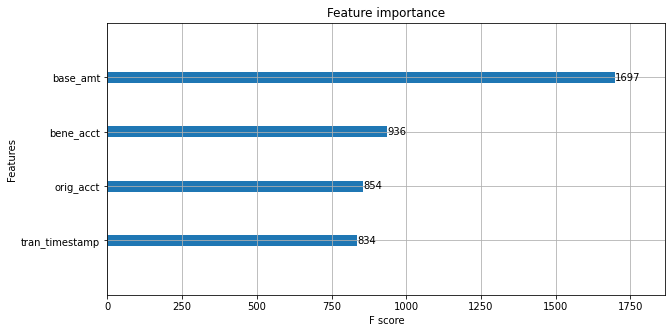

In [21]:
# Plot feature importance bar

plt.figure(figsize=(10,5))
xgb.plot_importance(best_xgb_clf, ax=plt.gca())
plt.show()

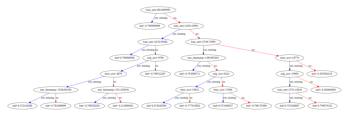

In [22]:
# Plot Decison Tree

xgb.plot_tree(best_xgb_clf)
plt.show()
# or xgb.to_graphviz(best_xgb_clf) for display a larger image

In [23]:
# Explain the model's predictions using SHAP on the validation set

explainer = shap.Explainer(best_xgb_clf)
shap_values = explainer(X_val)

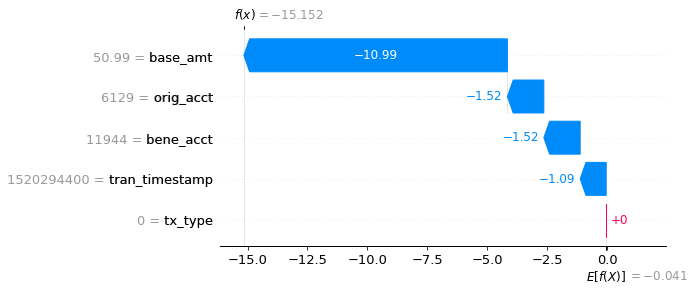

In [24]:
# Visualize the first prediction's explanation

shap.plots.waterfall(shap_values[0]) # you can change the prediction number to see a different one

The above explanation shows how each features contributing to push the model output from the base value (the average model output over the validation set we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. **from this chart you can see that the value for the first prediction is strongly negative, i.e. the model predicts that this transaction is very likely unsuspicious.** Another way to visualize the same explanation is to use a force plot below.

In [25]:
# Visualize the first prediction's explanation with a force plot

shap.initjs()
shap.plots.force(shap_values[0])

In [26]:
# Now get a random idx of illicit transaction prediction

dval = xgb.DMatrix(X_val, label=y_val)

pred_indices = (best_xgb_clf.predict(dval) > 0.5)
class_1_pred_indices = [idx for idx in range(len(pred_indices)) if pred_indices[idx] == True]

idx = random.choice(class_1_pred_indices)

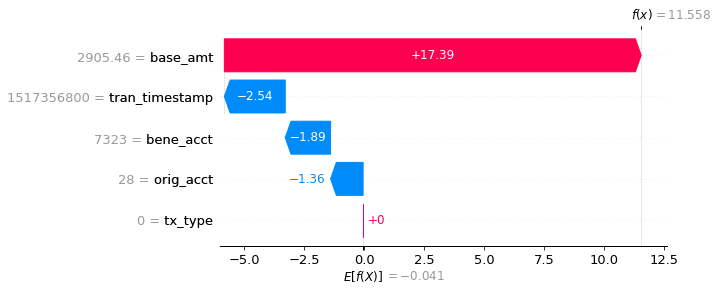

In [27]:
# Visualize prediction's explanation for random illicit transaction

shap.plots.waterfall(shap_values[idx])

In [28]:
# Visualize the same prediction's explanation with a force plot

shap.initjs()
shap.plots.force(shap_values[idx])

In [29]:
# Visualize all the training set predictions
# shap.plots.force(shap_values) RETURNS ERROR

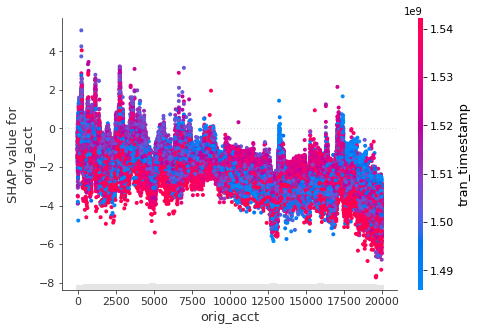

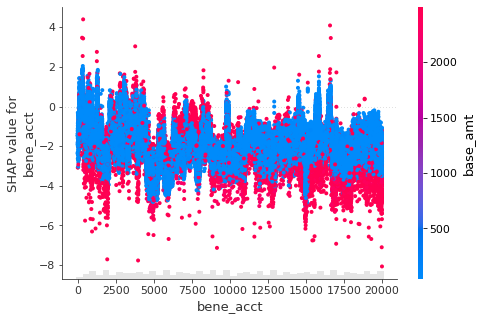

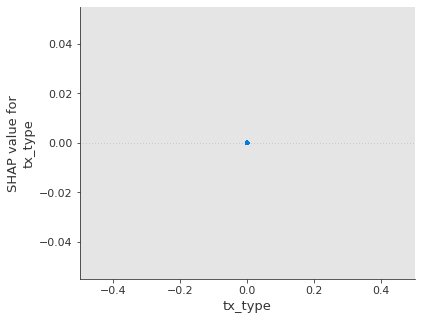

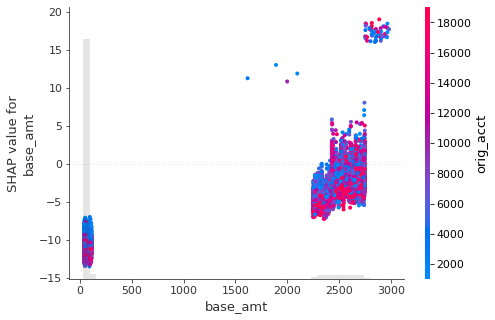

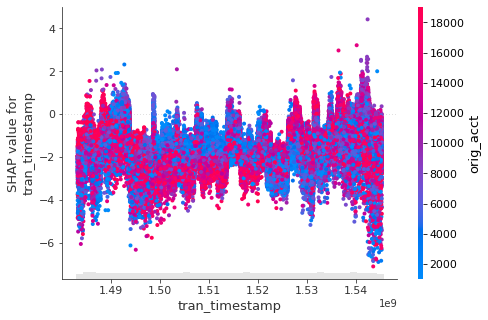

In [30]:
# Dependence scatter plots showing the effect of each single feature across the whole dataset

for feat in list(X_val.columns):
  shap.plots.scatter(shap_values[:, feat], color=shap_values)
  print('\n')

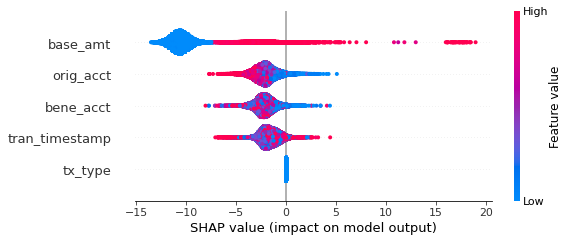

In [31]:
# Summarize the effects of all the features

shap.plots.beeswarm(shap_values)

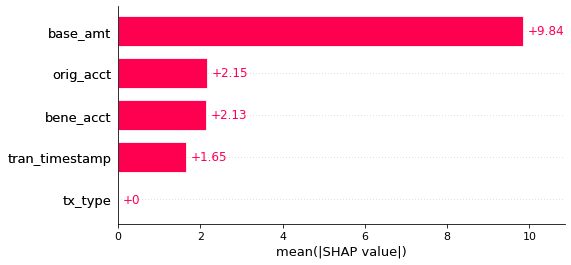

In [32]:
# Another visualization of feature importance

shap.plots.bar(shap_values)